In [1]:
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import warnings
from itertools import product
# from lmphoton.simulation import current_simulation as sim
from scipy.optimize import minimize
from scipy.constants import constants
import pandas as pd
import seaborn as sns
from sppd_dfb_laser import SPPDDFB, SPPDCLMPIC
from enablence_mux import EBMUX
from sppd_clm_optics import SPPDCLMOPTICS
from sppd_clm_calibration import SPPDCLMCAL
from sppd_clm_control import SPPDCLMCONTROL


In [2]:
target_grid_array = np.array([1301.47])*1e-9 

wavelength_A = np.array([1301.47])*1e-9

_sppd_clm_optics_A = SPPDCLMOPTICS(
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_A,
  name = "SPPDCLMOPTICS_LAMBDA_A",
  bw_lambda=0.1e-9, 
  il_dB = 3, 
  sb_atten_dB = 50,
  case_thermal_resistance=25
  )
#_sppd_clm_optics_A._case_thermal_resistance = 3e9

print("Wavelength bank A")

current_array = np.ones(1) * 0.125
_sppd_clm_optics_A.update(tc = 273+30.0, i_array=current_array)
for idd_laser in range(len(current_array)):
  print(f"{idd_laser}: {_sppd_clm_optics_A._lambda_array[idd_laser]*1e9:0.2f} nm")
for idd_target_wavelength in range(len(target_grid_array)):
  print(f"{idd_target_wavelength}: {_sppd_clm_optics_A._mpd_current_array[idd_target_wavelength]*1e6:0.2f} uA")
  


Wavelength bank A
0: 1299.38 nm
0: 3.88 uA


Nominal temperature for laser 0: 49.55 C
TEC set point temperature: 49.55 C
Peak MPD current for laser 0: 0.71 mA


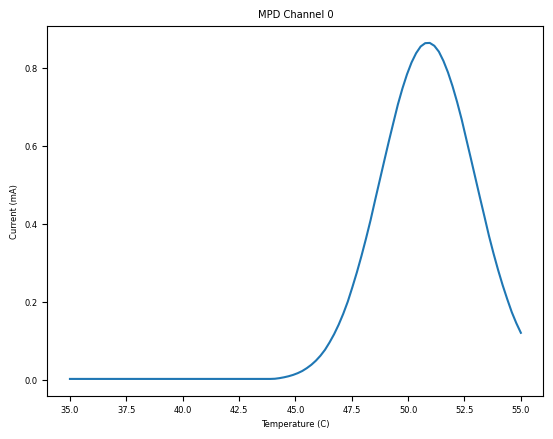

In [3]:
_sppd_cal = SPPDCLMCAL(_sppd_clm_optics_A)
cal_temperature_array = np.linspace(35, 55, 100) + 273
cal_current = 0.125
tec_set_point_temperature, nom_temp_array, mux_current_array, peak_current_array = _sppd_cal.calibrate(cal_temperature_array, cal_current)
# Print nominal temperature array for each laser
for idd_laser in range(len(current_array)):
  print(f"Nominal temperature for laser {idd_laser}: {nom_temp_array[idd_laser]-273:0.2f} C")
# Print tec set point temperature
print(f"TEC set point temperature: {tec_set_point_temperature-273:0.2f} C")
# Print peak current array for each laser
for idd_laser in range(len(current_array)):
  print(f"Peak MPD current for laser {idd_laser}: {peak_current_array[idd_laser]*1e3:0.2f} mA")
# Plot calibration per MUX channel (columns) and temperature (rows)
n_mpd_channels = len(target_grid_array)
# Set font size small
plt.rc('font', size=6)
fig, ax = plt.subplots(int(np.sqrt(n_mpd_channels)), int(np.sqrt(n_mpd_channels)))
for idd_mpd_channel in range(n_mpd_channels):
  _ax = ax
  _ax.plot(cal_temperature_array-273, mux_current_array[:, idd_mpd_channel]*1e3)
  _ax.set_xlabel("Temperature (C)")
  _ax.set_ylabel("Current (mA)")
  _ax.set_title(f"MPD Channel {idd_mpd_channel}")


(1300.0, 1305.0)

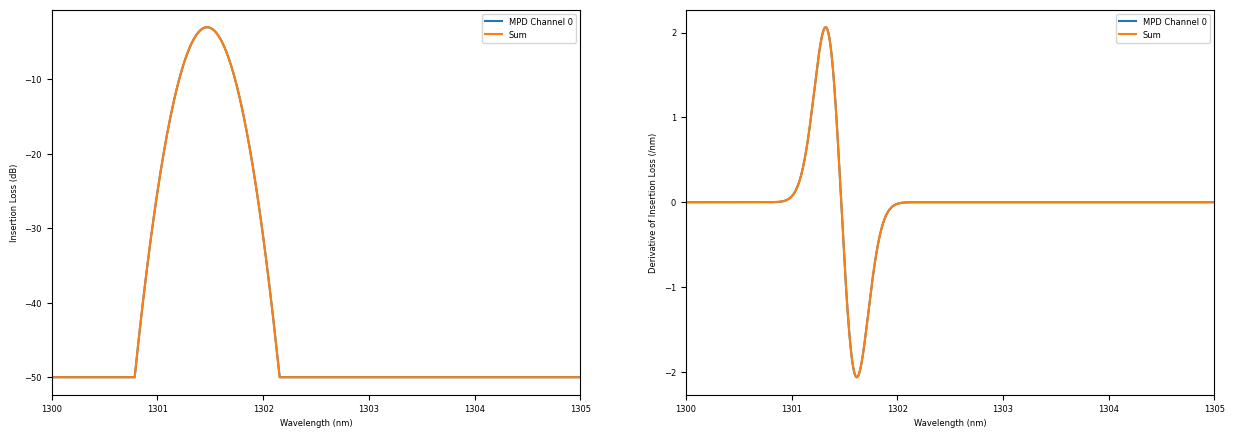

In [4]:
#What does the MUX transfer function look like?
# Insertion loss vs wavelength and its derivative
ebmux_tf_list = _sppd_clm_optics_A._ebmux.enablence_mux_tf_array_list
n_mpd_channels = len(target_grid_array)
# Set font size small
plt.rc('font', size=6)
# Plot everything on the same axis
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for idd_mpd_channel in range(n_mpd_channels):
  _ax = ax[0]
  _ax.plot(_sppd_clm_optics_A._ebmux.lambda_sweep*1e9, 10*np.log10(np.abs(ebmux_tf_list[idd_mpd_channel])**2), label=f"MPD Channel {idd_mpd_channel}")
  _ax.set_xlabel("Wavelength (nm)")
  _ax.set_ylabel("Insertion Loss (dB)")
  _ax.legend()
  _ax = ax[1]
  _ax.plot(_sppd_clm_optics_A._ebmux.lambda_sweep*1e9, np.gradient(ebmux_tf_list[idd_mpd_channel]**2,_sppd_clm_optics_A._ebmux.lambda_sweep*1e9), label=f"MPD Channel {idd_mpd_channel}")
  _ax.set_xlabel("Wavelength (nm)")
  _ax.set_ylabel("Derivative of Insertion Loss (/nm)")
  _ax.legend()
# To the first figure, sum everything up and plot
_ax = ax[0]
_ax.plot(_sppd_clm_optics_A._ebmux.lambda_sweep*1e9, 10*np.log10(np.abs(np.sum(ebmux_tf_list, axis=0))**2), label="Sum")
_ax.set_xlabel("Wavelength (nm)")
_ax.set_ylabel("Insertion Loss (dB)")
_ax.legend()
#zoom into 1300 - 1305 nm
_ax.set_xlim([1300, 1305])

# To the second figure, plot gradient of the sum
_ax = ax[1]
_ax.plot(_sppd_clm_optics_A._ebmux.lambda_sweep*1e9, np.gradient(np.sum(ebmux_tf_list, axis=0)**2,_sppd_clm_optics_A._ebmux.lambda_sweep*1e9), label="Sum")
_ax.set_xlabel("Wavelength (nm)")
_ax.set_ylabel("Derivative of Insertion Loss (/nm)")
_ax.legend()
_ax.set_xlim([1300, 1305])


In [5]:
from laser_control.pid import pid
dt = 0.5e-2
_sppd_clm_control = SPPDCLMCONTROL(sppd_clm_optics=_sppd_clm_optics_A, 
                                   tec_set_point_temperature =  tec_set_point_temperature,
                                   drive_current_array= 0.125*np.ones(1),
                                   mux_current_array =  peak_current_array,
                                   pid_tec = pid(kp=0.5, ki=10*dt, kd=10*dt, dt=dt, umax=3, umin=-3), 
                                   pid_idrive = [pid(kp=10, ki=100000*dt, kd=0.001, dt=dt) for i in range(1)],
                                   dt = dt)

t, laser_drive_current_array, laser_output_power_array, laser_wavelength_array, laser_junction_temperature_array, laser_mpd_current_array, t_case, hpf_sig_out, phase = _sppd_clm_control.run4()
tec_set_point_temperature
# Plot results





322.54545454545456

Text(0, 0.5, 'Phase')

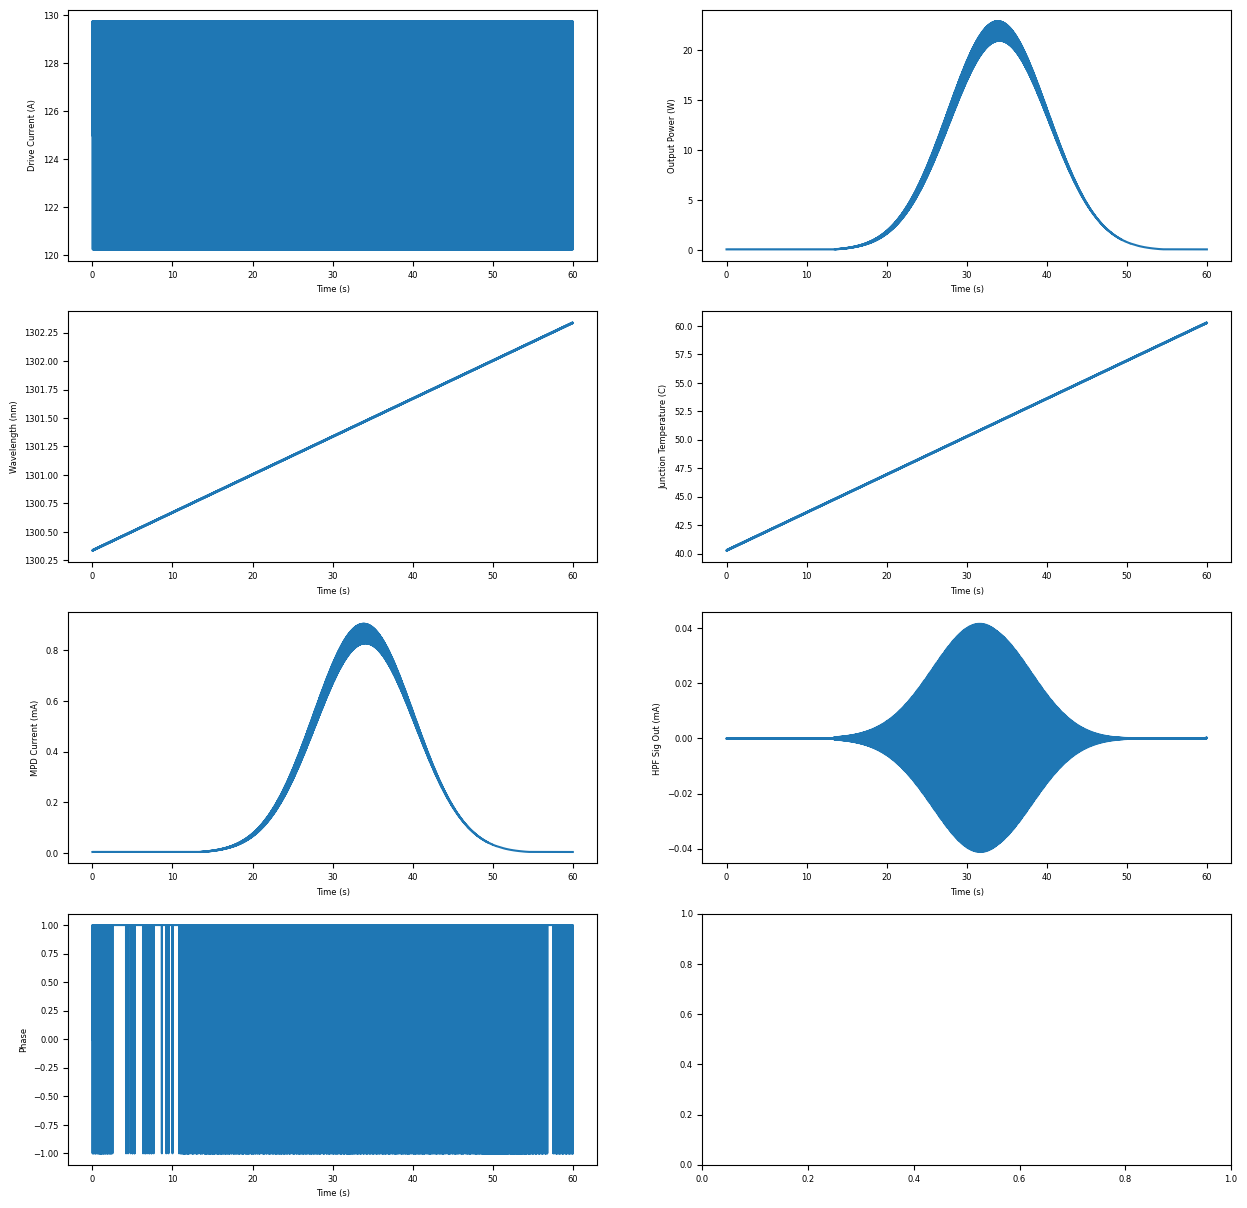

In [6]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
ax[0, 0].plot(t, laser_drive_current_array.T*1e3)
ax[0, 0].set_xlabel("Time (s)")
ax[0, 0].set_ylabel("Drive Current (A)")
ax[0, 1].plot(t, laser_output_power_array.T*1e3)  
ax[0, 1].set_xlabel("Time (s)")
ax[0, 1].set_ylabel("Output Power (W)")
#ax[0, 1].set_ylim([20, 22])
#ax[0, 1].set_xlim([32, 36])
ax[1, 0].plot(t, laser_wavelength_array.T*1e9)
ax[1, 0].set_xlabel("Time (s)")
ax[1, 0].set_ylabel("Wavelength (nm)")
#ax[1, 0].set_ylim([1301, 1302])
ax[1, 1].plot(t, laser_junction_temperature_array.T-273)
ax[1, 1].set_xlabel("Time (s)")
ax[1, 1].set_ylabel("Junction Temperature (C)")
ax[2, 0].plot(t, laser_mpd_current_array.T*1e3)
ax[2, 0].set_xlabel("Time (s)")
ax[2, 0].set_ylabel("MPD Current (mA)")
ax[2, 1].plot(t, hpf_sig_out.T*1e3)
ax[2, 1].set_xlabel("Time (s)")
ax[2, 1].set_ylabel("HPF Sig Out (mA)")
#ax[2,1].set_xlim([35, 40])
ax[3, 0].plot(t, phase.T)
ax[3, 0].set_xlabel("Time (s)")
ax[3, 0].set_ylabel("Phase")
#ax[3,0].set_xlim([50, 51])

In [7]:
dt = 1e-3
_sppd_clm_control = SPPDCLMCONTROL(sppd_clm_optics=_sppd_clm_optics_A, 
                                   tec_set_point_temperature =  tec_set_point_temperature-2,
                                   drive_current_array= 0.125*np.ones(1),
                                   mux_current_array =  peak_current_array,
                                   pid_tec = pid(kp=0.5, ki=10*dt, kd=10*dt, dt=dt, umax=3, umin=-3), 
                                   pid_idrive = [pid(kp=10, ki=10, kd=0, dt=dt) for i in range(1)],
                                   dt = dt)
t, laser_drive_current_array, laser_output_power_array, laser_wavelength_array, laser_junction_temperature_array, laser_mpd_current_array, q, i_tec, v_tec, t_case = _sppd_clm_control.run6()

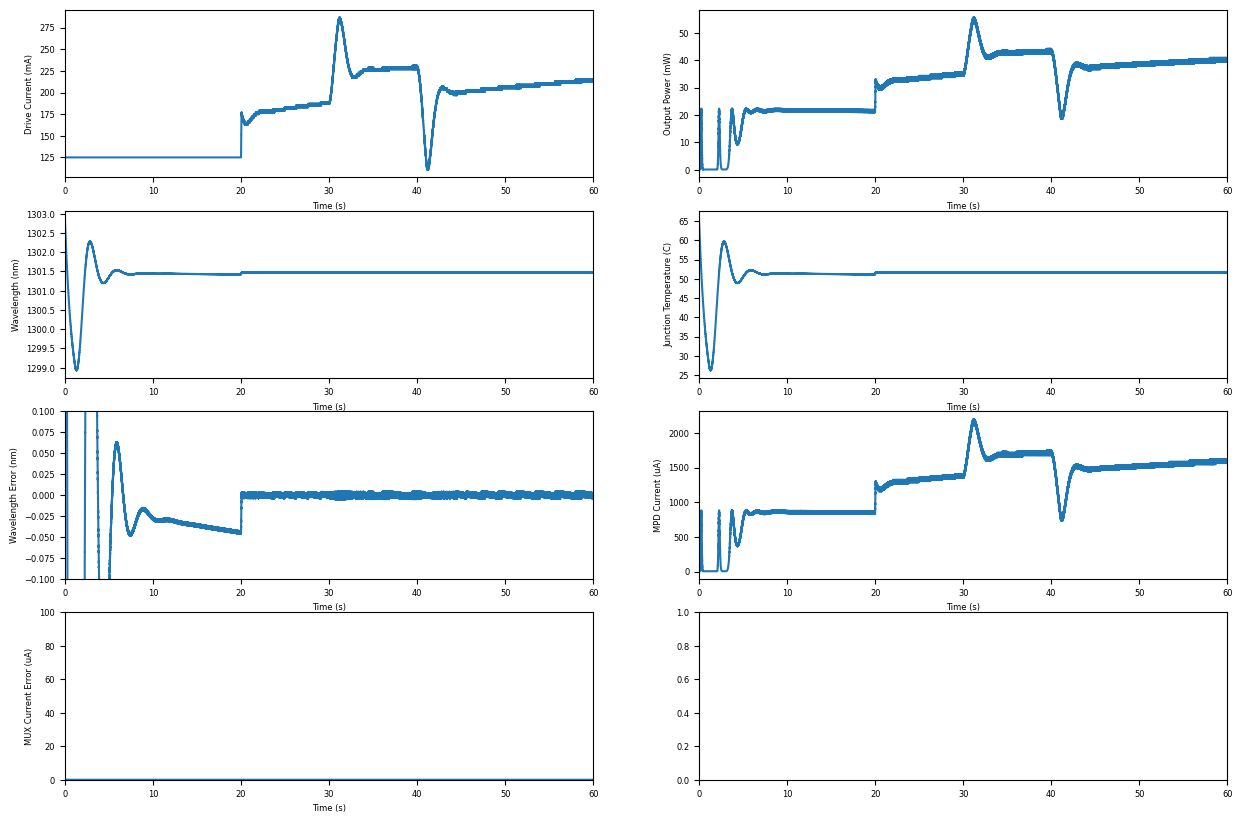

In [8]:
wavelength_error = (laser_wavelength_array - target_grid_array[::2].reshape(1,1))
fig, ax = plt.subplots(4, 2, figsize=(15, 10))
xlim = [0,60]
#xlim = [20,25]
ax[0, 0].plot(t, laser_drive_current_array.T*1e3)
ax[0, 0].set_xlabel("Time (s)")
ax[0, 0].set_ylabel("Drive Current (mA)")
ax[0, 1].plot(t, laser_output_power_array.T*1e3)
ax[0, 1].set_xlabel("Time (s)")
ax[0, 1].set_ylabel("Output Power (mW)")
ax[1, 0].plot(t, laser_wavelength_array.T*1e9)
ax[1, 0].set_xlabel("Time (s)")
ax[1, 0].set_ylabel("Wavelength (nm)")
ax[1, 1].plot(t, laser_junction_temperature_array.T-273)
ax[1, 1].set_xlabel("Time (s)")
ax[1, 1].set_ylabel("Junction Temperature (C)")
ax[2, 0].plot(t, wavelength_error.T*1e9)
ax[2, 0].set_xlabel("Time (s)")
ax[2, 0].set_ylabel("Wavelength Error (nm)")
ax[2, 0].set_ylim(-0.1, 0.1)
ax[2, 1].plot(t, laser_mpd_current_array.T*1e6)
ax[2, 1].set_xlabel("Time (s)")
ax[2, 1].set_ylabel("MPD Current (uA)")
ax[3, 0].plot(t, _sppd_clm_control._laser_mux_current_error.T*1e6)
ax[3, 0].set_xlabel("Time (s)")
ax[3, 0].set_ylabel("MUX Current Error (uA)")
ax[3, 0].set_ylim(0, 100)
#Set all axis to xlim
for i in range(4):
  for j in range(2):
    ax[i,j].set_xlim(xlim)

plt.show()

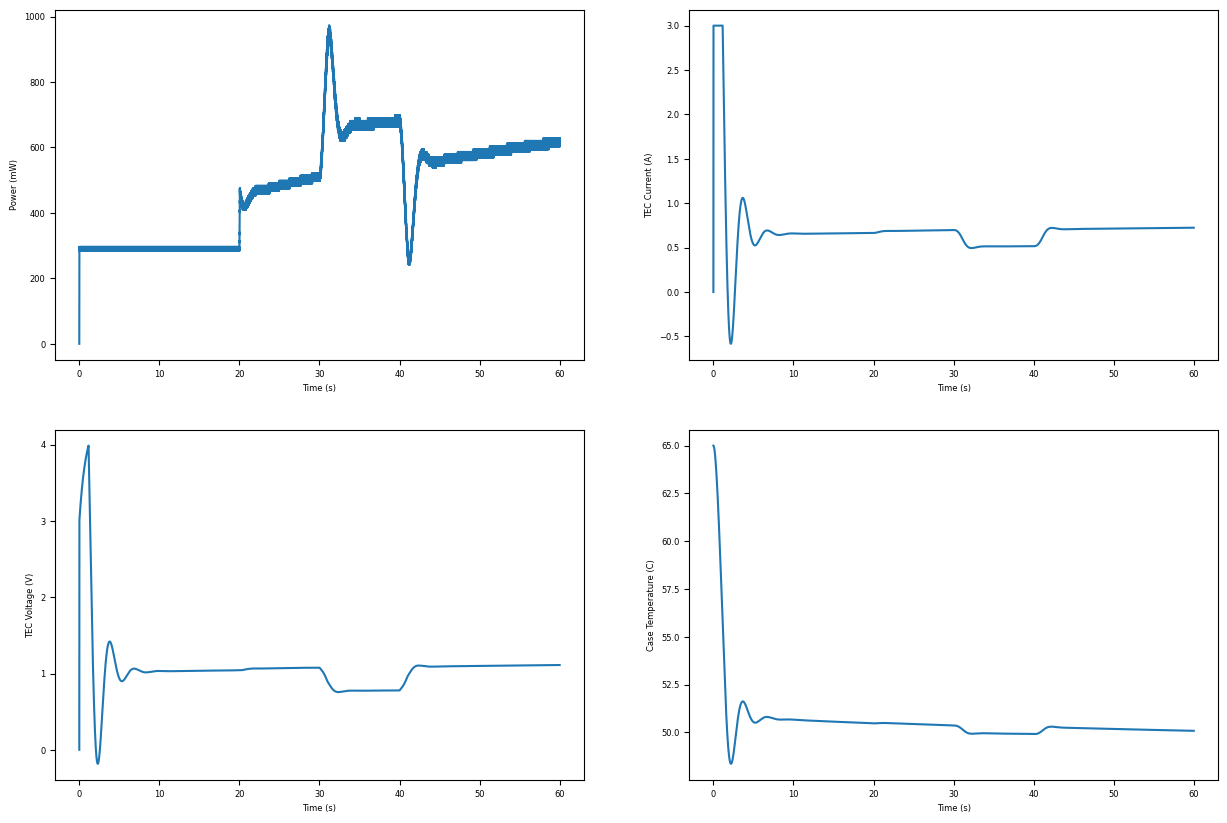

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(t, q*1e3)
ax[0, 0].set_xlabel("Time (s)")
ax[0, 0].set_ylabel("Power (mW)")
ax[0, 1].plot(t, i_tec)
ax[0, 1].set_xlabel("Time (s)")
ax[0, 1].set_ylabel("TEC Current (A)")
ax[1, 0].plot(t, v_tec)
ax[1, 0].set_xlabel("Time (s)")
ax[1, 0].set_ylabel("TEC Voltage (V)")
ax[1, 1].plot(t, t_case-273)
ax[1, 1].set_xlabel("Time (s)")
ax[1, 1].set_ylabel("Case Temperature (C)")
plt.show()

In [10]:
print('TEC Hot side: ', _sppd_clm_control._tec.Th - 273)
print('TEC Cold side: ', _sppd_clm_control._tec.Ta - 273)
print('Wavelength error:', np.mean(wavelength_error[:, -1])*1e9, 'nm')

TEC Hot side:  64.995
TEC Cold side:  50.054291161490426
Wavelength error: -0.0038382132212207492 nm
